This tutorial comtains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the Embedding Projector

## Representing text as numbers
Machine learning models take vectors (arrays of numbers) as imput. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. We will look at three strategies for doing so.


### One-hot encodings
As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentences is (cat, mat, on , sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word.

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vecotrs for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number
A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2].  This approach is efficient, Instead of a sparse vector, we not have a dense one (where all elements are full).

There are two downsides to this approach, however:
- The integer-encoding is arbitrary (it does not capture any relationship between words).
- An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weights for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encoding, this feature-weight combination is not meaningful.

### Word embeddings
Word embeddings give use a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand.
An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, there are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings are that are 9-dimensional (for small dataset), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, bug take more data to learn.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Using the Embedding layer
The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [0]:
embedding_layer = layers.Embedding(input_dim=1000, output_dim=5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem you model is trained on).

In [4]:
# If i pass an integer to an embedding layer,
# the result replaces each integer with the vector from the
# embedding table:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.03074482,  0.0377298 ,  0.03525838, -0.01288663, -0.02259805],
       [ 0.03574159, -0.01797842, -0.00686835, -0.03281524, -0.0320949 ],
       [ 0.00695553, -0.0179796 , -0.04896924, -0.03460749,  0.04733371]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)` where each entry is a sequence of integer. It can embed sequences of variable lengths. You could feed into the embedding layer above  batches with shape `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequence of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new las axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`

In [5]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer return a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. (word 하나가 embedding dimension이 되니까, Sequence 가 들어오면 Sequence x embedding dimension이 되겠지.) **To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use and RNN, Attiention, or pooling layer before passing it to a Dense layer.** This tutorial uses pooling because it's simplest.

## Learning embeddings from scratch
In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocess dataset.

In [6]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True, as_supervised=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary.

The "_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:

In [7]:
encoder = info.features["text"].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [0]:
# Movie reviews can be different lengths.
# We will use the `padded_batch` method to standadize the lengths of the reivews.
padded_shapes = ([None], ())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [11]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[4775, 3912, 8002, ..., 2678, 8038, 7975],
       [1397, 1425,  568, ...,    0,    0,    0],
       [  19, 1669, 6600, ...,    0,    0,    0],
       ...,
       [ 518, 4212,   34, ...,    0,    0,    0],
       [ 407,   77,   18, ...,    0,    0,    0],
       [2517,   97,    4, ...,    0,    0,    0]])

### Create a simple model
Create "Continuous bag of words" style model.

- Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors learned as the model trains. The vecotrs add a dimension to the output array. The resulting dimensions are `(batch, sequence, embedding)`.
- Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
- This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
- The last layer is densly connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [12]:
embedding_dim = 16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2500/2500 [==============================] - 35s 14ms/step - loss: 0.6383 - accuracy: 0.6994 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.4723 - accuracy: 0.8359 - val_loss: 0.4274 - val_accuracy: 0.8450
Epoch 3/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.3671 - accuracy: 0.8753 - val_loss: 0.3426 - val_accuracy: 0.8900
Epoch 4/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.3103 - accuracy: 0.8956 - val_loss: 0.3212 - val_accuracy: 0.8650
Epoch 5/10
2500/2500 [==============================] - 24s 10ms/step - loss: 0.2774 - accuracy: 0.9064 - val_loss: 0.2615 - val_accuracy: 0.9200
Epoch 6/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.2500 - accuracy: 0.9148 - val_loss: 0.2738 - val_accuracy: 0.8950
Epoch 7/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.2326 - accuracy: 0.9210 - val_loss: 0.2574 - va

With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

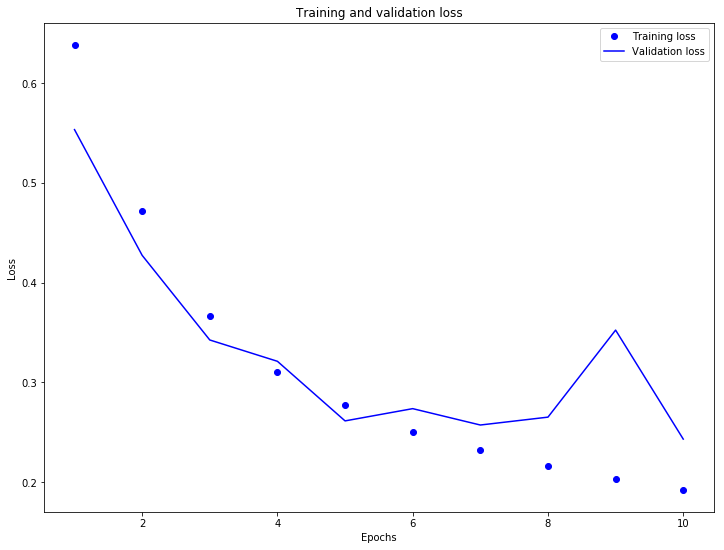

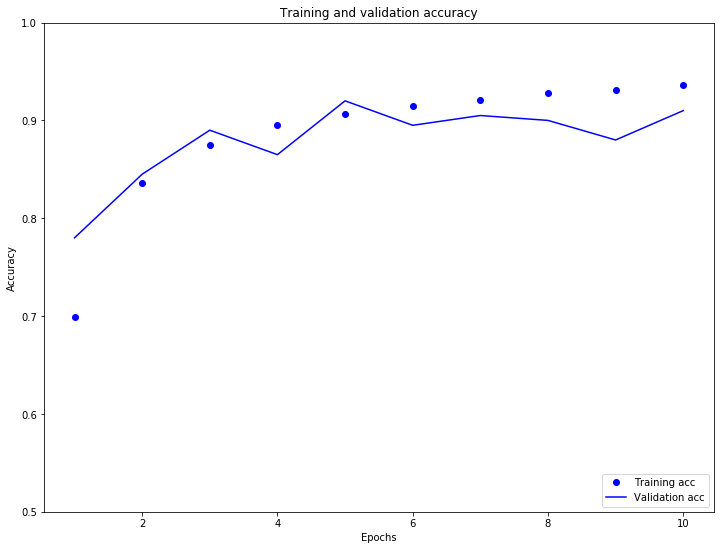

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

### Retrieve the learned embeddings
Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


We will now write the weights to disk. To use the `Embedding Projector`, we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [0]:
encoder = info.features["text"].encoder

In [0]:
import io

encoder = info.features["text"].encoder

out_v = io.open("vecs.tsv", "w", encoding="utf-8")
out_m = io.open("meta.tsv", "w", encoding="utf-8")

for num, word in enumerate(encoder.subwords):
  vec = weights[num + 1]
  out_m.write(word + "\n")
  out_v.write("\t".join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings
To visualize our embeddings we will upload them to the embedding projector.

Open the Embedding Projector (this can also run in a local TensorBoard instance).

Click on "Load data".

Upload the two files we created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".